In [29]:
#!pip install pandas openpyxl

In [30]:
#!pip install tqdm

# This notebook is used for final project predict the sneaker price

In [1]:
import pandas as pd
import openpyxl

In [2]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import numpy

In [3]:
import os
data_folder_fp = "data_folder"
os.makedirs(data_folder_fp, exist_ok=True)
tensor_data_fp = os.path.join(data_folder_fp, "pytorch_data.pt")
(X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor) = torch.load(tensor_data_fp, weights_only=False)

In [4]:
print(f"X_train_tensor.shape={X_train_tensor.shape}")
print(f"X_val_tensor.shape  ={X_val_tensor.shape}")
print(f"X_test_tensor.shape ={X_test_tensor.shape}")
print(f"y_train_tensor.shape={y_train_tensor.shape}")
print(f"y_val_tensor.shape  ={y_val_tensor.shape}")
print(f"y_test_tensor.shape ={y_test_tensor.shape}")

X_train_tensor.shape=torch.Size([58271, 671])
X_val_tensor.shape  =torch.Size([19423, 671])
X_test_tensor.shape =torch.Size([19422, 671])
y_train_tensor.shape=torch.Size([58271, 1])
y_val_tensor.shape  =torch.Size([19423, 1])
y_test_tensor.shape =torch.Size([19422, 1])


In [5]:
# define a NN model 

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output for regression
        )
    
    def forward(self, x):
        return self.fc(x)

In [6]:
def train_model(X_train_tensor, 
                y_train_tensor, 
                X_val_tensor, 
                y_val_tensor,
                X_test_tensor, 
                y_test_tensor, 
                num_epochs=200, 
                opt_method="mse",
                model_folder="models/nn",
                image_folder="images/nn"):
    input_size = X_train_tensor.shape[1]
    model = RegressionModel(input_size)

    # Define the loss function and optimizer
    if opt_method == "mse":
        criterion = nn.MSELoss()
    elif opt_method == "mae":
        criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    temp_min = float('inf')
    os.makedirs(model_folder, exist_ok=True)
    os.makedirs(image_folder, exist_ok=True)
    model_fp = os.path.join(model_folder, f"{opt_method}_{num_epochs}.pth")
    image_fp = os.path.join(image_folder, f"{opt_method}_{num_epochs}.jpg")
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            val_loss = val_loss.item()
            if val_loss < temp_min:
                temp_min = val_loss
                torch.save(model.state_dict(), model_fp)
                # print(f"model_saved to {saved_model_fp}")
    # print("the min val loss is: ", temp_min) 
    model.load_state_dict(torch.load(model_fp, weights_only=True))
    
    criterion_b = nn.L1Loss()
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predictions = model(X_test_tensor)
        test_loss = criterion_b(predictions, y_test_tensor)
        print(f'Test Loss for {opt_method} {num_epochs}: {test_loss.item():.4f}')
    vis_res(train_losses, val_losses, num_epochs, opt_method=opt_method, image_fp=image_fp, test_loss=test_loss)

def vis_res(train_losses, val_losses, num_epochs, opt_method="", image_fp="", test_loss=0.0):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation Loss -- {num_epochs} epochs, loss = {opt_method} test_loss={test_loss}')
    plt.legend()
    plt.savefig(image_fp)
    plt.show()
    
    

Test Loss for mae 1000: 27.8699


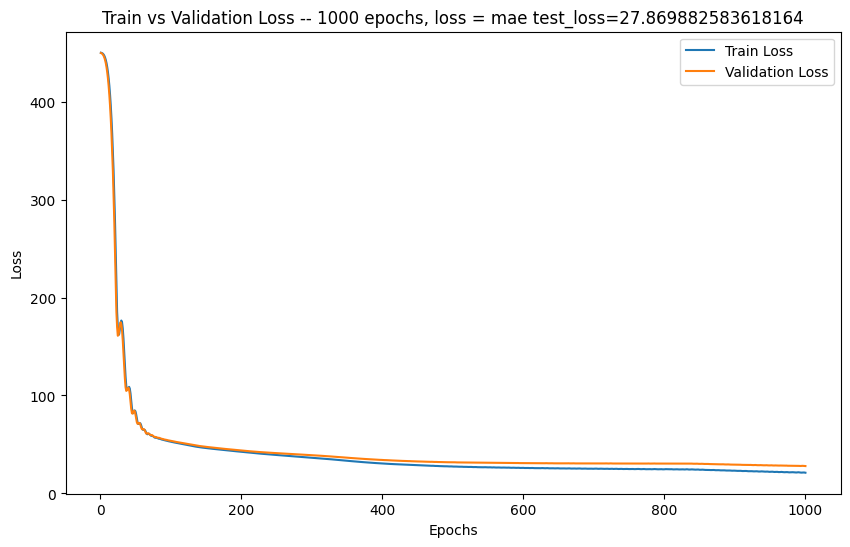

Test Loss for mse 1000: 26.7178


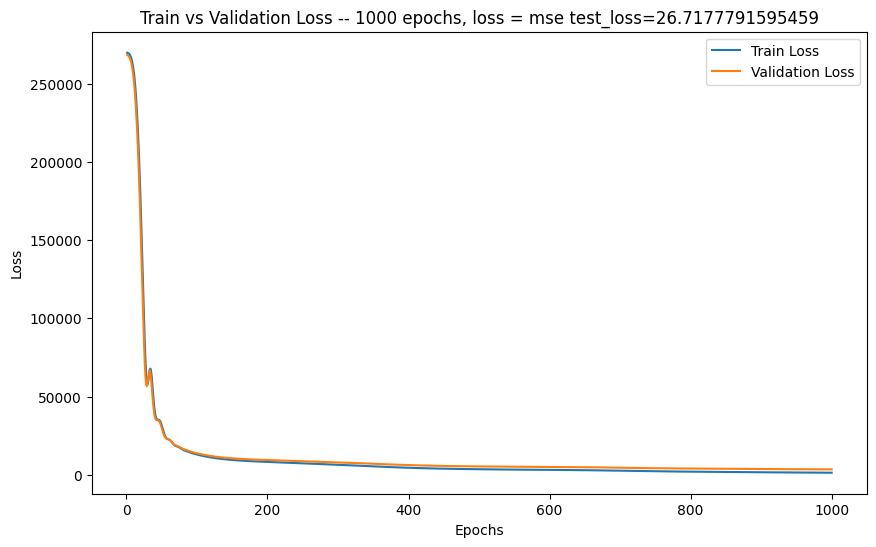

Test Loss for mae 1500: 26.1071


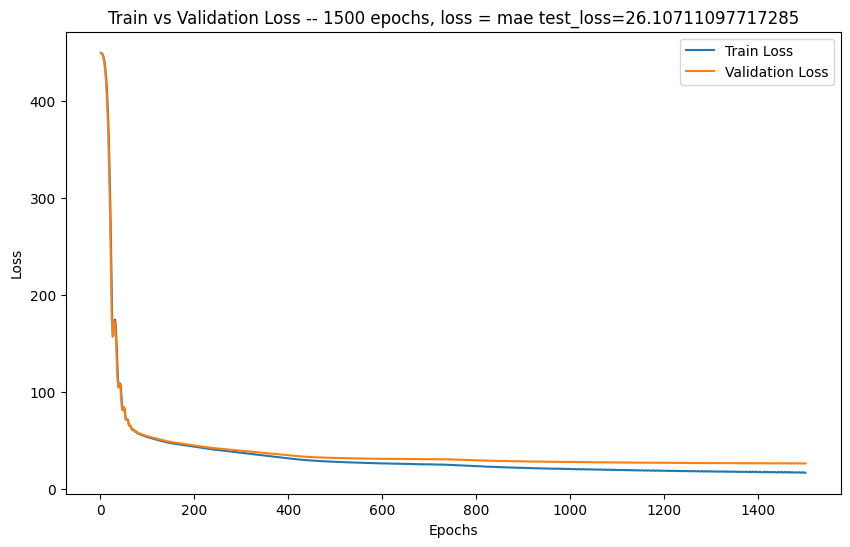

Test Loss for mse 1500: 31.4984


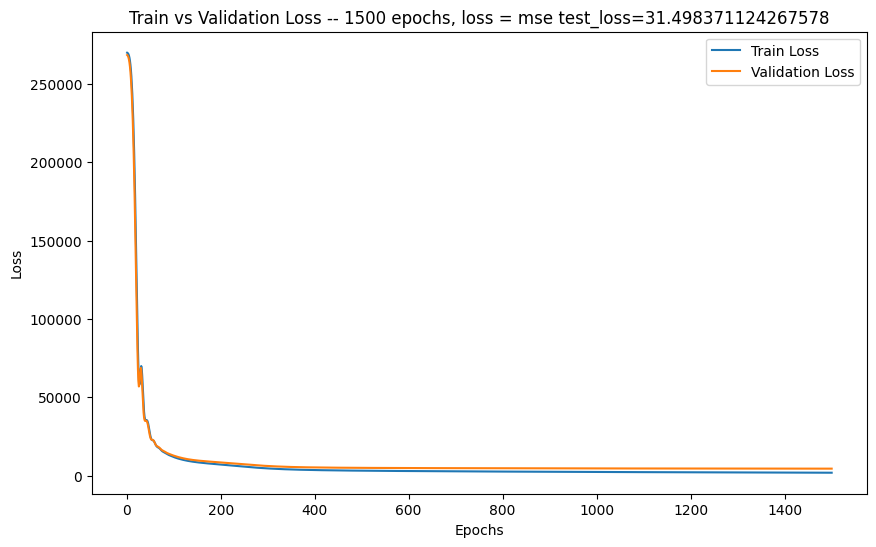

Test Loss for mae 2000: 25.2878


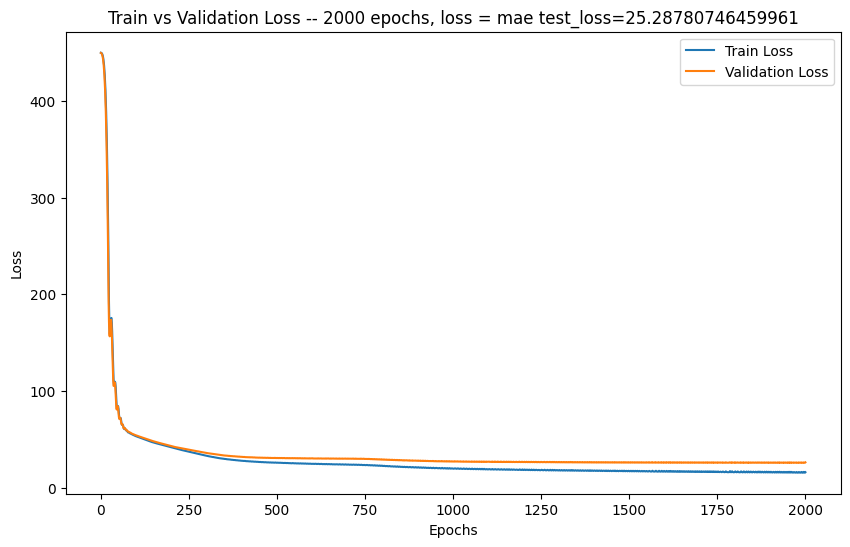

Test Loss for mse 2000: 28.8244


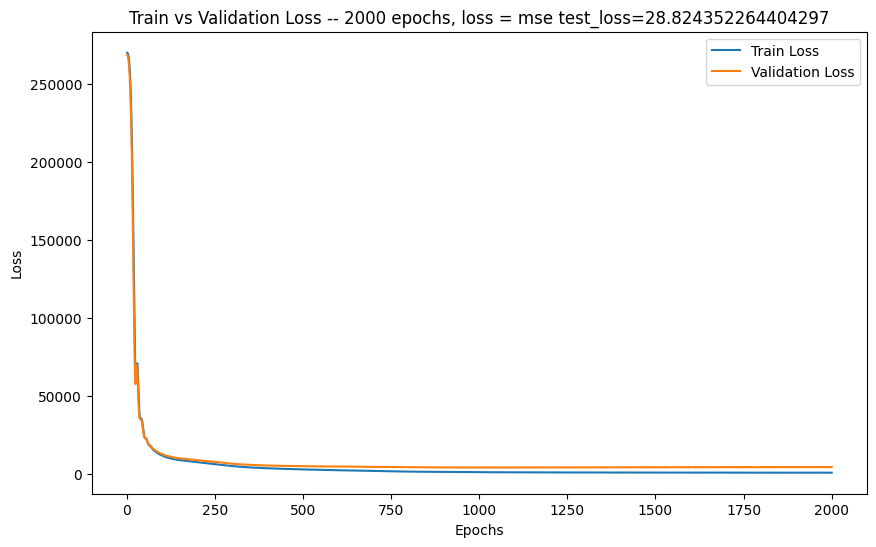

In [7]:
training_epochs = [1000, 1500, 2000]
loss_types = ["mae", "mse"]
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)
for num_epochs in training_epochs:
    for loss_type in loss_types:
        train_model(X_train_tensor, 
                    y_train_tensor, 
                    X_val_tensor, 
                    y_val_tensor,
                    X_test_tensor, 
                    y_test_tensor,
                    num_epochs,
                    loss_type,
                    model_folder="models/nn")

In [8]:
def demo_price(model_fp, data_sample, categorical_features, numerical_features, encoder, scaler):
    # Convert to DataFrame
    data_sample_df = pd.DataFrame(data_sample)
    # Apply one-hot encoding to categorical columns
    new_data_cat = encoder.transform(data_sample_df[categorical_features])
    
    # Scale numerical columns
    new_data_num = scaler.transform(data_sample_df[numerical_features])
    
    # Combine processed numerical and categorical features
    new_data_processed = np.hstack([new_data_num, new_data_cat])
    
    # Convert to PyTorch tensor
    new_data_tensor = torch.tensor(new_data_processed, dtype=torch.float32)
    print(f"new_data_tensor = {new_data_tensor.shape}, new_data_num={new_data_num.shape},new_data_cat={new_data_cat.shape} ")
    # load model
    model = RegressionModel(new_data_tensor.shape[1])
    model.load_state_dict(torch.load(model_fp, weights_only=True))
    model.eval()  # Set model to evaluation mode
    # Predict sale price for the new data
    with torch.no_grad():
        predicted_price = model(new_data_tensor)
    
    # Print the predicted sale price
    print(f"Predicted Sale Price: {predicted_price.item():.2f}")

In [9]:
best_model_fp = "models/nn/mae_1500.pth"
# best_model_fp = "training_mae_2000.pt"

new_data = {
    'Order Date': ['2022-01-01'],
    'Brand': ['Yeezy'],
    'Sneaker Name': ['Adidas-Yeezy-Boost-350-V2-Core-Black-Red'],
    'Retail Price': [220],
    'Release Date': ['2018-02-11'],
    'Shoe Size': [11.0],
    'Buyer Region': ['California']
}
categorical_features = ['Order Date', 'Brand', 'Sneaker Name', 'Release Date', 'Buyer Region']
numerical_features = ['Retail Price', 'Shoe Size']

from utils import CustomOneHotEncoder, StandardScaler
# xtrain_data_fp = os.path.join(data_folder_fp, "xtrain.pt")
# X_train = torch.load(xtrain_data_fp, weights_only=False)
# encoder = CustomOneHotEncoder()
# scaler  = StandardScaler()
# encoder.fit(X_train[categorical_features])
# scaler.fit(X_train[categorical_features])
encoder_scaler_fp = os.path.join(data_folder_fp, "encoder_scaler.pt")
encoder, scaler = torch.load(encoder_scaler_fp, weights_only=False)
demo_price(best_model_fp, new_data, categorical_features, numerical_features, encoder, scaler)

new_data_tensor = torch.Size([1, 671]), new_data_num=(1, 2),new_data_cat=(1, 669) 
Predicted Sale Price: 488.76


In [ ]:
print(y_test)
print(X_test)